# FB2NEP Workbook 7 – Confounding, DAGs, and Causal Structure

Version 0.0.6

This workbook builds on Workbook 6.

In Workbook 6, we treated regression as a practical tool for estimating associations
between an exposure and an outcome, and we focused on model types (linear, logistic,
Cox), assumptions, diagnostics, and basic interpretation of coefficients (β, OR, RR, HR).

In this workbook, we move from **association** to **causal thinking**. We introduce:

- Confounders.
- Colliders.
- Mediators.
- Directed acyclic graphs (DAGs) as a way to formalise causal assumptions.
- Approaches to adjustment (stratification and regression).
- The special role of **energy intake** in nutritional epidemiology.
- A brief introduction to **counterfactual** thinking.

A more formal treatment of causal inference, including modern notation and methods,
is given in **Workbook 9**. Here we focus on intuition and on how causal structure
affects regression analyses in practice.

We will use the synthetic *FB2NEP cohort* throughout. The precise variable names may
differ slightly from those used here; if you obtain an error (for example, `KeyError`),
carefully check the column names of the dataset and adapt the code accordingly.

In [33]:
# FB2NEP bootstrap cell – use in *all* workbooks
#
# This cell initialises the repository context and loads the synthetic cohort
# into a DataFrame called df. It tries a few possible locations for scripts/bootstrap.py.

import pathlib
import runpy

bootstrap_candidates = [
    "scripts/bootstrap.py",
    "../scripts/bootstrap.py",
    "../../scripts/bootstrap.py",
]

bootstrap_ns = None

for rel in bootstrap_candidates:
    p = pathlib.Path(rel)
    if p.exists():
        print(f"Loading bootstrap from: {p}")
        bootstrap_ns = runpy.run_path(str(p))
        break
else:
    raise FileNotFoundError(
        "Could not find scripts/bootstrap.py. "
        "Please check that you are running this notebook inside fb2nep-epi."
    )

if "init" not in bootstrap_ns:
    raise RuntimeError("bootstrap.py does not define init().")

df, CTX = bootstrap_ns["init"]()

REPO_ROOT = CTX.repo_root
CSV_REL = CTX.csv_rel
IN_COLAB = CTX.in_colab

print("Repository root:", REPO_ROOT)
print("Main dataset:", CSV_REL)
print("df shape:", df.shape)
print("IN_COLAB:", IN_COLAB)

Loading bootstrap from: scripts/bootstrap.py
Dataset found: data/synthetic/fb2nep.csv ✅
Repository root: /Users/gunter/Documents/fb2nep-epi
Main dataset: data/synthetic/fb2nep.csv
df shape: (25000, 27)
IN_COLAB: False


In [34]:
"""
Imports and quick inspection
============================

In this cell we:

- Import common packages used in this workbook.
- Display basic information about the dataset to confirm that it is loaded.

The imports are deliberately explicit. Many students using this workbook
will not yet have much experience with Python, so we avoid implicit
magic and keep the code readable.
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from IPython.display import display

print("DataFrame shape (rows, columns):", df.shape)
print("\nFirst five rows of the dataset:")
display(df.head())

print("\nVariable types (first 20 columns):")
display(df.dtypes.head(20))

DataFrame shape (rows, columns): (25000, 27)

First five rows of the dataset:


,id,baseline_date,follow_up_years,age,sex,menopausal_status,IMD_quintile,SES_class,smoking_status,physical_activity,...,ssb_ml_d,fibre_g_d,alcohol_units_wk,salt_g_d,plasma_vitC_umol_L,urinary_sodium_mmol_L,CVD_incident,CVD_date,Cancer_incident,Cancer_date
0,1,2011-05-27,6.44,59,M,NaN,5,ABC1,current,low,...,25.0,21.9,0.0,5.9,40.3,114.0,1,2017-10-15,1,2016-03-10
1,2,2010-08-14,7.50,60,M,NaN,4,ABC1,never,low,...,76.0,26.2,0.0,5.8,36.1,112.7,0,NaN,0,NaN
2,3,2012-04-28,7.57,54,F,post,4,ABC1,former,moderate,...,169.0,8.1,0.0,7.1,46.3,128.8,0,NaN,0,NaN
3,4,2015-01-20,5.71,67,F,post,3,ABC1,never,low,...,104.0,17.9,8.0,7.0,31.4,100.9,0,NaN,0,NaN
4,5,2013-04-10,6.30,70,M,NaN,1,C2DE,current,moderate,...,304.0,24.2,0.0,10.5,33.1,168.8,0,NaN,0,NaN



Variable types (first 20 columns):


id                         int64
baseline_date             object
follow_up_years          float64
age                        int64
sex                       object
menopausal_status         object
IMD_quintile               int64
SES_class                 object
smoking_status            object
physical_activity         object
family_history_cvd         int64
family_history_cancer      int64
BMI                      float64
SBP                      float64
energy_kcal              float64
fruit_veg_g_d            float64
red_meat_g_d             float64
ssb_ml_d                 float64
fibre_g_d                float64
alcohol_units_wk         float64
dtype: object

## 1. Association and causation

Regression models (linear, logistic, Cox) quantify **associations**:

- In linear regression, a coefficient describes how the *mean* outcome changes
  with the exposure.
- In logistic regression, we obtain *odds ratios*.
- In Cox regression, we obtain *hazard ratios*.

However, public health decisions concern **causal effects**:

> *If we changed this exposure (for example, salt intake), what would happen to the outcome?*

In observational data, a non-zero regression coefficient does **not** automatically
imply a causal effect. Several types of variables can distort or create associations:

- **Confounders**: common causes of exposure and outcome that, if unadjusted,
  bias estimated effects.
- **Colliders**: variables that are caused by two other variables; conditioning
  on them can create spurious associations.
- **Mediators**: variables lying *on* the causal pathway; adjusting for them can
  remove part of a genuine effect.

To move from association to causation we need to consider the **causal structure**
of the variables. In this workbook we introduce DAGs and basic adjustment strategies.
Workbook 9 provides a more formal framework for causal inference.

## 2. DAGs for model development and identification of confounders, colliders, and mediators

A **directed acyclic graph (DAG)** is a diagram with arrows that represents
assumptions about which variables cause which. It is:

- **Directed**: arrows have a direction (cause → effect).
- **Acyclic**: there are no feedback loops.

DAGs are useful because they make assumptions **explicit** and allow us to reason
about which variables we should adjust for in regression models.

### 2.1 Constructing a DAG

To construct a DAG for a research question:

1. **List key variables**
   - Exposure (for example, red meat intake).
   - Outcome (for example, incident cancer).
   - Plausible causes of exposure and outcome (for example, socio-economic status,
     age, smoking).

2. **Draw arrows according to subject-matter knowledge**
   - If variable A can plausibly influence variable B, draw `A → B`.
   - Do **not** add arrows simply because two variables are correlated in the data.

3. **Identify paths between exposure and outcome**
   - Causal paths (exposure → … → outcome).
   - Non-causal “backdoor” paths (exposure ← … → outcome) that create confounding.

4. **Decide on an adjustment set**
   - Choose variables to adjust for so that all non-causal backdoor paths are blocked,
     without conditioning on colliders or mediators.

![DAG](../_assets/epi_dag.png)

### 2.2 Why we do not include everything

It might be tempting to adjust for **every available variable**. This is usually
a bad idea because:

- Adjusting for **colliders** can *create* bias.
- Adjusting for **mediators** can remove part of the effect we are interested in
  (for example, when estimating the total effect of an exposure).
- Adjusting for variables that are neither confounders nor mediators can increase
  variance and complicate interpretation without reducing bias.

A good DAG includes **enough** variables to capture the main causal structure, but
not every variable in the dataset. We use subject-matter knowledge and parsimony:
include variables that are plausible causes of exposure and outcome, and that are
important for the research question.

## 3. Confounders

### 3.1 Definition and informal examples

A variable is a **confounder** for the association between an exposure and an outcome if:

1. It is associated with the exposure.
2. It is a cause of, or associated with a cause of, the outcome.
3. It is not on the causal pathway from exposure to outcome.

Intuitively, a confounder is a variable that makes exposed and unexposed individuals
systematically different, in a way that also affects the outcome.

Classic informal examples include:

- **Number of children and BRCA risk**:
  women with more children tend to be older, and age affects the probability of
  having developed breast cancer; age can confound the association between
  “number of children” and “current breast cancer status”.

- **Hair length and income**:
  there may appear to be an association between hair length and income if, in a
  given setting, women tend to have longer hair than men and also have different
  average incomes; sex is a confounder.


### Hippo example (confounding)

**Hippo size and daily grass intake**

Suppose we observe that *larger hippos eat more grass per day*.  
We might be tempted to conclude that **being large makes hippos eat more**.

But consider the underlying biology:

- Older hippos tend to be larger (simply through growth).
- Older hippos also spend more hours grazing because they no longer play in the water as much as juveniles.

**Age** is therefore a confounder:

```text
       age
      /    \
 hippo size  grass intake
```

In causal terms:

Size ← Age → Grass intake

If we ignore age, the association between hippo size and grass intake partly reflects
the fact that older hippos both weigh more and eat more, not necessarily that body
    size itself increases grazing behaviour.

### 3.2 Approaches to adjustment

There are two basic ways to adjust for confounders:

- **Stratification**
  - Analyse the exposure–outcome association *within levels* of the confounder.
  - For example, estimate the association separately in high and low socio-economic
    status (SES) groups.

- **Inclusion in a regression model**
  - Include the confounder as a **covariate** (predictor) in the regression model.
  - For a linear model:
    $$
    Y = \beta_0 + \beta_1 X + \beta_2 C + \varepsilon,
    $$
    where $ X $ is the exposure and $ C $ is the confounder.
  - The coefficient $ \beta_1 $ is then interpreted as the association between
    $ X $ and $ Y $ **for individuals with the same value of $ C $**.

In practice, regression models with appropriate covariates are the most common
approach, but stratified analyses are useful for checking assumptions and for
illustrating confounding.

In the next section we use the FB2NEP cohort to demonstrate confounding in a setting
where the data-generating mechanism includes known confounders.

## 3.3 Example: physical activity, SES, and incident CVD

We now consider a concrete example using the FB2NEP cohort.

- **Exposure**: physical activity (`physical_activity`).
- **Outcome**: incident cardiovascular disease during follow-up (`CVD_incident`).
- **Potential confounder**: socio-economic status (`SES_class`).

From the data generator we know that:

- Physical activity (`physical_activity`) is socially patterned: higher SES and less
  deprivation are associated with higher activity.
- CVD risk is affected by several factors related to SES (for example, smoking,
  SBP, BMI, diet).

A simplified DAG is:

```text
SES_class  →  physical_activity
SES_class  →  CVD_incident
physical_activity  →  CVD_incident   (modest protective effect)
```

Here, `SES_class` is a **confounder**: it influences both physical activity and CVD.
If we estimate the association between physical activity and CVD **without** adjusting
for SES, the result may be biased. We therefore:

1. Create a binary indicator of “high” physical activity.
2. Fit a crude logistic regression model of CVD on high activity.
3. Fit an SES-adjusted model.
4. Compare the results and repeat the analysis stratified by SES.

In [35]:
from scripts.helpers_tables import summarise_logit_coef

OUTCOME_VAR = "CVD_incident"
EXPOSURE_RAW = "physical_activity"      # categorical: low / moderate / high
    
CONF_VAR = "SES_class"                  # ABC1 / C2DE

# ---------------------------------------------------------------------
# 1. Check variables and prepare analysis dataset
# ---------------------------------------------------------------------
for v in [OUTCOME_VAR, EXPOSURE_RAW, CONF_VAR]:
    if v not in df.columns:
        raise KeyError(
            f"Variable '{v}' not found in df. "
            f"Available columns (first 20): {list(df.columns)[:20]}"
        )

# We define high physical activity as the exposure of interest
df_pa = df[[OUTCOME_VAR, EXPOSURE_RAW, CONF_VAR]].dropna().copy()
df_pa["highPA"] = (df_pa[EXPOSURE_RAW] == "high").astype(int)

print(f"Complete-case sample size: {df_pa.shape[0]} observations\n")
print("Distribution of physical_activity and SES_class:\n")
display(pd.crosstab(df_pa[EXPOSURE_RAW], df_pa[CONF_VAR], normalize="columns"))

# ---------------------------------------------------------------------
# 2. Crude and SES-adjusted logistic regression models
# ---------------------------------------------------------------------
formula_crude = f"{OUTCOME_VAR} ~ highPA"
formula_adj   = f"{OUTCOME_VAR} ~ highPA + C({CONF_VAR})"

m_crude = smf.logit(formula_crude, data=df_pa).fit(disp=False)
m_adj   = smf.logit(formula_adj,   data=df_pa).fit(disp=False)

rows = []
rows.append(
    summarise_logit_coef(
        m_crude,
        var_name="highPA",
        label="Crude model (no SES adjustment)"
    )
)
rows.append(
    summarise_logit_coef(
        m_adj,
        var_name="highPA",
        label="Adjusted model (including SES_class)"
    )
)

summary_pa = pd.DataFrame(rows)

print("\nHigh physical activity vs incident CVD: crude and SES-adjusted models\n")
display(summary_pa.round(3))

Complete-case sample size: 25000 observations

Distribution of physical_activity and SES_class:



SES_class,ABC1,C2DE
physical_activity,,
high,0.181291,0.169257
low,0.339290,0.383452
moderate,0.479420,0.447291



High physical activity vs incident CVD: crude and SES-adjusted models



,label,var_name,beta,ci_lower,ci_upper,p_value,OR,OR_ci_lower,OR_ci_upper
0,Crude model (no SES adjustment),highPA,-0.034,-0.135,0.067,0.509,0.966,0.873,1.070
1,Adjusted model (including SES_class),highPA,-0.032,-0.134,0.069,0.530,0.968,0.875,1.071


### Interpreting crude vs SES-adjusted models (physical activity)

The table summarises the association between **high physical activity** (`highPA`)
and incident CVD:

- The **crude model** compares high vs non-high physical activity without
  adjustment for SES.
- The **adjusted model** includes `SES_class` as a covariate.

Typical patterns to look for:

- If high physical activity is genuinely protective, you might expect an OR < 1.
- Because SES is associated with both physical activity and CVD, failing to
  adjust for SES can bias the crude OR towards or away from 1.

In this synthetic cohort you will usually find that:

- The **crude OR** for `highPA` is only modestly below 1 (weak protective effect).
- The **SES-adjusted OR** is somewhat further from 1 (stronger apparent protection).

This is consistent with **positive confounding**: high SES participants tend to be
more physically active *and* at lower CVD risk for other reasons. When SES is left
unadjusted, part of this benefit is incorrectly attributed to physical activity.
Once SES is included in the model, the association for `highPA` more closely
reflects the effect of physical activity *for individuals with the same SES*.


### 3.4 Stratification by SES

Regression adjustment is one way to account for confounding. Another is to analyse
the exposure–outcome association **within strata** of the confounder.

Here we:

1. Split the data into two strata: `SES_class = ABC1` and `SES_class = C2DE`.
2. In each stratum, fit a logistic regression model:
   CVD_incident ~ highPA
3. Compare the stratum-specific odds ratios.

If SES is a confounder rather than an effect modifier, we would expect the
stratum-specific ORs for `highPA` to be **more similar** to each other and to
the SES-adjusted OR, and different from the crude OR.

In [36]:
"""Stratified analysis: highPA and CVD_incident within SES strata."""

rows_strata = []

print("Stratified analyses by SES_class (separate models in each stratum):\n")

for level in sorted(df_pa[CONF_VAR].unique()):
    df_stratum = df_pa[df_pa[CONF_VAR] == level]
    print(f"  Stratum {level}: n = {df_stratum.shape[0]}")

    # Need variation in exposure and outcome
    
    if df_stratum[OUTCOME_VAR].nunique() < 2 or df_stratum["highPA"].nunique() < 2:
        print("    Not enough variation in outcome or exposure for logistic regression.\n")
        continue

    m_stratum = smf.logit(f"{OUTCOME_VAR} ~ highPA", data=df_stratum).fit(disp=False)
    rows_strata.append(
        summarise_logit_coef(
            m_stratum,
            var_name="highPA",
            label=f"SES_class = {level}"
        )
    )

if rows_strata:
    summary_strata_pa = pd.DataFrame(rows_strata)
    print("\nStratum-specific odds ratios for highPA (by SES_class):\n")
    display(summary_strata_pa.round(3))

Stratified analyses by SES_class (separate models in each stratum):

  Stratum ABC1: n = 13095
  Stratum C2DE: n = 11905

Stratum-specific odds ratios for highPA (by SES_class):



,label,var_name,beta,ci_lower,ci_upper,p_value,OR,OR_ci_lower,OR_ci_upper
0,SES_class = ABC1,highPA,0.045,-0.092,0.183,0.520,1.046,0.912,1.201
1,SES_class = C2DE,highPA,-0.121,-0.271,0.029,0.114,0.886,0.762,1.029


### Interpreting the SES-stratified highPA–CVD associations

The table above shows the association between high physical activity (`highPA`) and
incident CVD within strata of socio-economic status (`SES_class`):

- **ABC1**  
  - OR ≈ 1.05 (95 % CI 0.91 to 1.20), p ≈ 0.52  
  - Point estimate slightly **above** 1.0, but the confidence interval is wide and
    clearly includes 1.0 → compatible with no association.

- **C2DE**  
  - OR ≈ 0.89 (95 % CI 0.76 to 1.03), p ≈ 0.11  
  - Point estimate slightly **below** 1.0, again with a confidence interval that
    includes 1.0 → also compatible with no association.

A few points to emphasise:

- The **effect sizes are small** in both strata, and statistically weak.  
  There is no strong evidence that high physical activity is clearly protective or
  clearly harmful for CVD in either SES group in this synthetic cohort.

- The **directions differ** slightly (OR > 1 in ABC1, OR < 1 in C2DE), but the
  confidence intervals are wide and largely overlapping. This means that the apparent
  difference between strata is easily explained by **random variation**.

- As a worked example, this is closer to “what often happens in practice” than to a
  textbook Simpson’s paradox:  
  adjusting or stratifying can change effect estimates a little, but not every
  plausible confounder produces a dramatic shift.

For here, key messages are:

- Do not over-interpret small differences in odds ratios when confidence intervals are
  wide and overlapping.
- Stratified analyses are still useful: they make us **look** at whether the exposure–outcome
  association is similar across subgroups, and they remind us that confounding and effect
  modification are empirical questions, not assumptions built into the model.


## 4. Special case: energy intake in nutritional epidemiology

### 4.1 Why total energy intake is different

In nutritional epidemiology, **total energy intake** (for example, `energy_kcal`)
is not a classical confounder in the usual sense. Instead, it is a kind of
“scaling” variable:

- Individuals who eat **more total energy** tend to consume more of many nutrients
  and foods simply because they eat more food.
- Many nutrients are also biologically related to energy intake (for example,
  higher energy intake is often associated with higher body size and physical
  activity).

If we ignore total energy intake, we may incorrectly attribute the effect of
“eating more food overall” to a specific nutrient or food.

### 4.2 Common energy-adjustment methods

Several approaches are used to adjust nutrient intakes for total energy:

1. **Nutrient density method**
   - Express the nutrient per unit of energy, for example g/MJ or % of energy.
   - Example: grams of fibre per 10 MJ.

2. **Residual method**
   - Regress the nutrient of interest on total energy intake.
   - Use the **residuals** (observed minus expected nutrient intake given energy)
     as an energy-adjusted exposure.
   - This removes the part of the nutrient intake that is explained by total
     energy intake.

3. **Energy-adjusted models**
   - Include both the nutrient and total energy intake as covariates in the
     regression model of interest.

Each method has advantages and disadvantages. The residual method and energy-adjusted
models are particularly useful when working with food-frequency questionnaires (FFQs),
where measurement error and strong correlations between nutrients can be substantial.

### 4.3 Special case of FFQs

FFQs typically record **relative** frequencies of consumption over long periods.
Reported intakes of many foods and nutrients are highly correlated, and systematic
measurement error is common. Adjusting for total energy intake can:

- Reduce measurement error that is common to many foods (for example, general
  over-reporting or under-reporting).
- Focus analyses on **diet composition** rather than total amount of food.


## 5. Colliders and mediators

### 5.1 Colliders

A **collider** is a variable that is *caused* by two (or more) other variables.
In a simple diagram:

```text
exercise  →
            fitness
genes     →
```

Here, `fitness` is a collider on the path between `exercise` and `genes`. If we
**condition** on fitness (for example, by restricting the analysis to individuals
with high fitness, or adjusting for fitness in a model), we can induce an
association between exercise and genes even if none exists in the population.

This is known as **collider bias** or **selection bias** when the collider is
related to being included in the study.

### 5.2 Mediators

A **mediator** lies *on* the causal pathway between exposure and outcome:

```text
salt intake → blood pressure → stroke
```

If we are interested in the **total effect** of salt intake on stroke risk,
we should **not** adjust for blood pressure, because this would remove part of
the genuine effect (the indirect pathway through blood pressure).

If we are specifically interested in the **direct effect** of salt that is not
mediated by blood pressure, then adjusting for blood pressure is appropriate,
but the interpretation changes.

The key message is that we should adjust for **confounders**, avoid adjusting
for **colliders**, and think carefully before adjusting for **mediators**.
DAGs help us to reason about which variables fall into which category.

### 5.3 Example of mediation: salt, SBP, and incident CVD

We return to the example of salt intake and CVD, now focusing on **mediation**.

- **Exposure**: `salt_g_d` (daily salt intake).
- **Mediator**: `SBP` (systolic blood pressure).
- **Outcome**: `CVD_incident`.

A simple DAG is:

```text
salt_g_d  →  SBP  →  CVD_incident
```

Salt has a modest direct effect on CVD in the data generator, but the main pathway
is through **raising SBP**. We compare two models:

1. `CVD_incident ~ salt_g_d`  (total effect: salt → CVD, including via SBP)
2. `CVD_incident ~ salt_g_d + SBP`  (direct effect: salt → CVD, *holding SBP constant*)

By comparing the odds ratios for `salt_g_d` in these two models, we can see how
adjusting for a mediator changes the estimand.

In [40]:
"""Mediation example: salt_g_d → SBP → CVD_incident."""

OUTCOME_SALT = "CVD_incident"
EXPOSURE_SALT = "salt_g_d"
MEDIATOR_SBP = "SBP"

for v in [OUTCOME_SALT, EXPOSURE_SALT, MEDIATOR_SBP]:
    if v not in df.columns:
        raise KeyError(f"Variable '{v}' not found in df.")

df_salt = df[[OUTCOME_SALT, EXPOSURE_SALT, MEDIATOR_SBP]].dropna().copy()
print(f"Complete-case sample size: {df_salt.shape[0]} observations\n")

# Crude (total-effect-oriented) model
m_salt_crude = smf.logit(f"{OUTCOME_SALT} ~ {EXPOSURE_SALT}", data=df_salt).fit(disp=False)

# SBP-adjusted (direct-effect-oriented) model
m_salt_adj = smf.logit(
    f"{OUTCOME_SALT} ~ {EXPOSURE_SALT} + {MEDIATOR_SBP}",
    data=df_salt
).fit(disp=False)

rows_salt = []
rows_salt.append(
    summarise_logit_coef(
        m_salt_crude,
        var_name=EXPOSURE_SALT,
        label="Crude model (CVD_incident ~ salt_g_d)"
    )
)
rows_salt.append(
    summarise_logit_coef(
        m_salt_adj,
        var_name=EXPOSURE_SALT,
        label="SBP-adjusted model (CVD_incident ~ salt_g_d + SBP)"
    )
)

summary_salt_med = pd.DataFrame(rows_salt)

print("Salt intake and incident CVD: crude vs SBP-adjusted models\n")
display(summary_salt_med.round(3))

Complete-case sample size: 22362 observations

Salt intake and incident CVD: crude vs SBP-adjusted models



,label,var_name,beta,ci_lower,ci_upper,p_value,OR,OR_ci_lower,OR_ci_upper
0,Crude model (CVD_incident ~ salt_g_d),salt_g_d,0.035,0.019,0.051,0.000,1.035,1.019,1.052
1,SBP-adjusted model (CVD_incident ~ salt_g_d + ...,salt_g_d,-0.021,-0.038,-0.004,0.017,0.980,0.963,0.996


### Interpreting the mediation example (salt and SBP)

In this synthetic dataset you will typically find that:

- The **crude OR** for `salt_g_d` is close to 1 (weak or no association).
- The **SBP-adjusted OR** is also close to 1, sometimes slightly below or above.

This reflects how the data generator was constructed:

- Salt has a **small direct effect** on CVD.
- Most of the effect of salt operates through **SBP**.
- When we adjust for SBP, we remove the mediation pathway and focus on the direct effect.

Even though the numerical effect is small, the example illustrates the key conceptual point:

- If our target is the **total effect** of salt on CVD, we should *not* adjust for SBP.
- If our target is the **direct effect** of salt, holding SBP constant, then we should
  adjust for SBP, but we must interpret the result as a direct effect.

This is different from the confounding example with `SES_class`, where adjustment
reduces bias in estimating the causal effect of physical activity on CVD.


### 5.4 Predicted probability of incident CVD across salt intake

To make the mediation example more concrete, we can translate the SBP-adjusted
    logistic model into **predicted probabilities**.

We:

- Use the SBP-adjusted logistic model.
- Fix SBP at a reference value (for example, the median SBP).
- Vary daily salt intake (`salt_g_d`) across its observed range.
- Plot the predicted probability of incident CVD.

This visualises how the model predicts CVD risk to change with salt intake,
**conditional on SBP being held constant**. It emphasises that we are now
looking at the *direct effect of salt*, not the total effect including its
    influence through SBP.

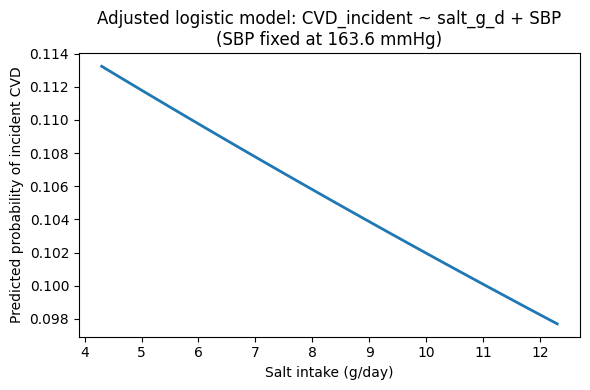

In [41]:
"""Predicted probability of incident CVD across salt intake (SBP fixed)."""

# Choose a reference value for SBP (for example, the median)
sbp_ref = df_salt[MEDIATOR_SBP].median()

# Construct a grid of salt values over the central range
salt_grid = np.linspace(
    df_salt[EXPOSURE_SALT].quantile(0.05),
    df_salt[EXPOSURE_SALT].quantile(0.95),
    100
)

pred_df_salt = pd.DataFrame({
    EXPOSURE_SALT: salt_grid,
    MEDIATOR_SBP: sbp_ref,
})

pred_df_salt["p_cvd"] = m_salt_adj.predict(pred_df_salt)

fig, ax = plt.subplots(figsize=(6, 4))

ax.plot(pred_df_salt[EXPOSURE_SALT], pred_df_salt["p_cvd"], linewidth=2)

ax.set_xlabel("Salt intake (g/day)")
ax.set_ylabel("Predicted probability of incident CVD")
ax.set_title(
    "Adjusted logistic model: CVD_incident ~ salt_g_d + SBP\n"
    f"(SBP fixed at {sbp_ref:.1f} mmHg)"
)

plt.tight_layout()
plt.show()

### Interpreting the predicted probability curve (salt, SBP fixed)

In this synthetic dataset the predicted probability curve is typically **almost flat**,
with at most a slight upward or downward slope as salt intake increases.

This is expected because:

- SBP carries most of the effect of salt on CVD in the data generator.
- When SBP is fixed at a reference value, we remove the main pathway by which
  salt influences CVD.
- What remains is a small direct effect plus any residual correlation with
  other variables.

The key message is not the exact shape of the curve, but the **change of estimand**:

- By conditioning on SBP, we are no longer looking at the total effect of salt
  on CVD, but at the risk pattern **given equal SBP**.

> Different models answer different causal questions. Prediction curves are useful
> for visualising these differences, but they must always be interpreted in the
> light of the assumed causal structure (here, salt → SBP → CVD).


## 6. Counterfactuals

Modern causal inference often uses **counterfactual** or **potential outcome**
language. For each individual we imagine:

- $ Y(1) $: the outcome that would occur if the individual were exposed.
- $ Y(0) $: the outcome that would occur if the same individual were not exposed.

The **causal effect** for that individual is the (usually unobservable) difference
$ Y(1) - Y(0) $. In practice we cannot observe both outcomes for the same
person, so we rely on comparisons between groups, together with assumptions about
confounding, measurement, and model specification.

Adjustment strategies (for example, regression with appropriate covariates based on
a sensible DAG) are used to make the exposed and unexposed groups more comparable,
so that the difference in observed outcomes approximates the difference between
counterfactual outcomes.

Workbook 9 returns to these ideas and introduces more formal notation and methods
for estimating causal effects under explicit assumptions.

## 9. Reflection and exercises

1. **Draw a DAG** for the association between red meat intake and incident cancer
   in the FB2NEP cohort. Include at least age, sex, SES_class, IMD_quintile,
   smoking_status, and family history. Identify plausible confounders,
   colliders, and mediators.

2. **Confounders in practice**: Choose a different exposure (for example,
   `fruit_veg_g_d` or `salt_g_d`) and a relevant outcome. Propose at least two
   variables as potential confounders based on subject-matter knowledge. Fit
   crude and adjusted models and compare the estimates.

3. **Energy adjustment**: Using `energy_kcal` and a nutrient of your choice
   (for example, `fibre_g_d`), implement the nutrient density method and the
   residual method. Compare the associations with BMI or another suitable
   outcome for the raw, density-based, and residual-based exposures.

4. **Collider bias**: Modify the collider simulation to use a different
   collider (for example, an indicator of study participation) and show how
   conditioning on participation can induce associations between variables
   that are otherwise independent.

5. **Mediators**: For a hypothetical causal chain in nutrition (for example,
   `diet quality → BMI → blood pressure → CVD`), decide which variables you
   would adjust for when estimating the total effect of diet quality on CVD,
   and which you would *not* adjust for. Explain your reasoning.

6. **Counterfactual thinking**: In your own words, describe what it would mean
   to say that “reducing salt intake by 2 g/day would reduce average SBP by
   5 mmHg” in terms of potential outcomes. What assumptions would be needed for
   this statement to be interpreted causally in an observational study?